In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mbeml.constants import unique_cores

In [3]:
plt.style.use("mbeml.mbeml")

In [4]:
data_dir = Path("../../data/")

df_train = pd.read_csv(data_dir / "training_data.csv")
df_val = pd.read_csv(data_dir / "validation_data.csv")

model_dir = Path("../../models/")

In [5]:
ligands_train = df_train["name"].str.split("_").str[2:]
ligands_val = df_val["name"].str.split("_").str[2:]

In [6]:
ligands_train

0       [[OH]-[PH]-[PH]-[OH], [OH]-[PH]-[PH]-[OH], [OH...
1       [[OH]-[S]-[S]-[OH], [OH]-[S]-[S]-[OH], [OH]-[S...
2       [[O]=[CH]-[CH]=[O], [O]=[CH]-[CH]=[O], [O]=[CH...
3       [[PH2]-[CH]=[CH]-[PH2], [PH2]-[CH]=[CH]-[PH2],...
4       [[PH2]-[PH]-[PH]-[PH2], [PH2]-[PH]-[PH]-[PH2],...
                              ...                        
1439    [imidazolidinone, imidazolidinone, imidazolidi...
1440    [phosphine, phosphine, phosphine, phosphine, p...
1441    [phosphorine, phosphorine, phosphorine, phosph...
1442    [water, water, water, water, acetonitrile, sul...
1443           [water, water, water, water, water, water]
Name: name, Length: 1444, dtype: object

In [7]:
def get_num_unique_ligands(ligands):
    num_unique_ligands = []
    for ligs, uniques in zip(ligands, list(map(set, ligands))):
        counts = sorted([ligs.count(l) for l in uniques], reverse=True)
        if counts == [6]:
            num_unique_ligands.append("homoleptic")
        elif counts == [5, 1]:
            num_unique_ligands.append("5+1")
        elif counts == [4, 2]:
            # Distinguish cis and trans
            if ligs[-1] == ligs[-2]:
                num_unique_ligands.append("4+2 (trans)")
            elif ligs[-1] == ligs[-3]:
                num_unique_ligands.append("4+2 (cis)")
            else:
                NotImplementedError(ligs)
        elif counts == [4, 1, 1]:
            if ligs[0] == ligs[1] == ligs[2] == ligs[3]:
                num_unique_ligands.append("4+1+1 (trans)")
            else:
                NotImplementedError(ligs)
        else:
            raise NotImplementedError(counts)
        # num_unique_ligands.append(
        #     "|".join(sorted([str(ligands.count(l)) for l in uniques], reverse=True))
        # )
    assert len(num_unique_ligands) == len(ligands)
    return num_unique_ligands

In [8]:
num_unique_train = get_num_unique_ligands(ligands_train)
num_unique_val = get_num_unique_ligands(ligands_val)
assert set(num_unique_train) == set(num_unique_val)

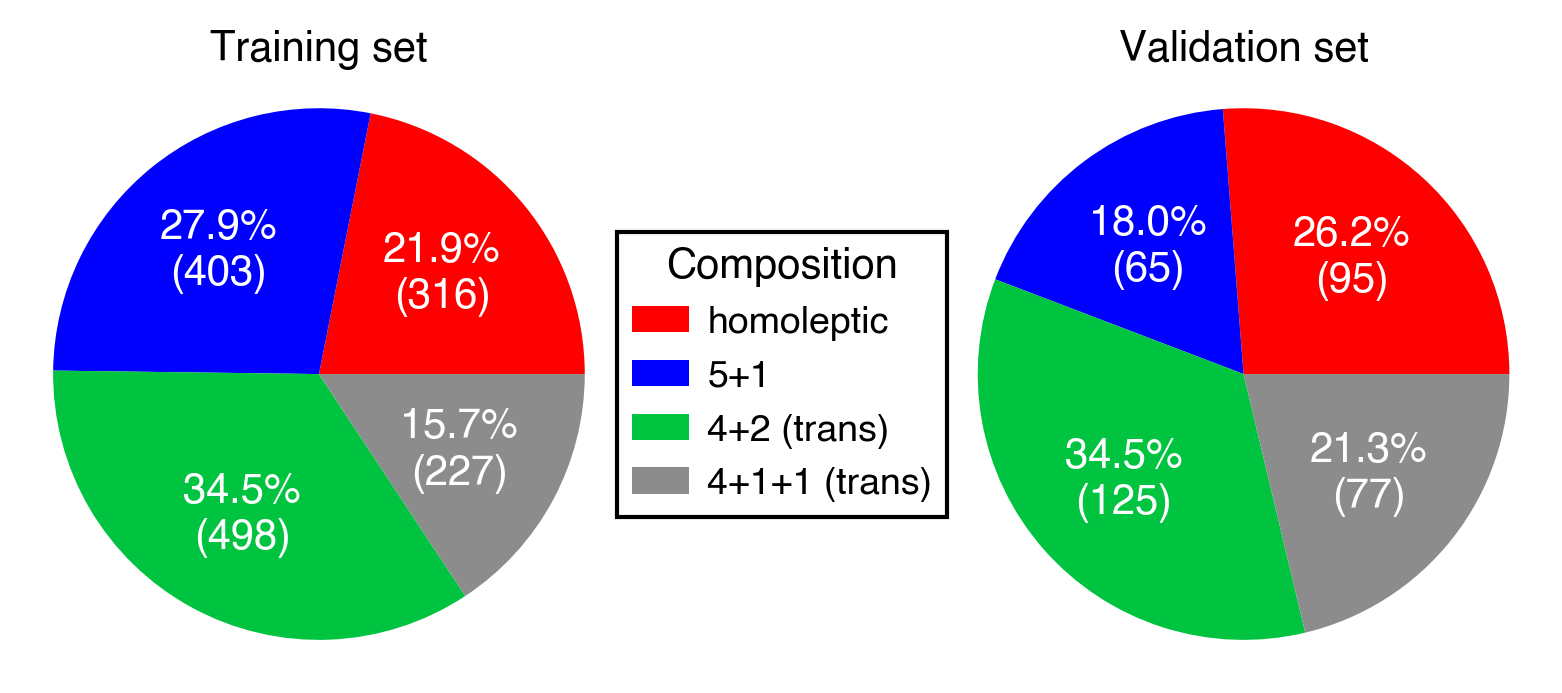

In [9]:
unique_compositions = ["homoleptic", "5+1", "4+2 (trans)", "4+1+1 (trans)"]
gridspec_kw = {
    "left": 0.03,
    "right": 0.97,
    "top": 0.88,
    "bottom": 0.05,
    "hspace": 0.0,
    "wspace": 0.6,
}
fig, axes = plt.subplots(
    figsize=(0.8 * 6.66, 0.7 * 3.33),
    ncols=2,
    sharey=True,
    sharex=True,
    gridspec_kw=gridspec_kw,
)


def func(pct, allvals):
    absolute = int(np.round(pct / 100.0 * np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"


counts_train = [num_unique_train.count(sym) for sym in unique_compositions]
axes[0].pie(
    counts_train,
    autopct=lambda pct: func(pct, counts_train),
    textprops=dict(color="w"),
    radius=1.15,
)
axes[0].set_title("Training set")
axes[0].set_xlim(-1, 1)
axes[0].set_ylim(-1, 1)
counts_val = [num_unique_val.count(sym) for sym in unique_compositions]
wedges, texts, autotexts = axes[1].pie(
    counts_val,
    autopct=lambda pct: func(pct, counts_val),
    textprops=dict(color="w"),
    radius=1.15,
)
axes[1].legend(
    wedges,
    unique_compositions,
    loc="center right",
    bbox_to_anchor=(0.02, 0.5),
    title="Composition",
)
axes[1].set_title("Validation set")
fig.savefig("plots/ligand_symmetries.pdf")

# Number of charged ligands per complex

In [16]:
total_ligand_charge = df_train[[f"lig{i}_charge" for i in range(1, 7)]].sum(axis=1)

In [39]:
cores = df_train[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
num_charged = {}
for core in unique_cores:
    mask = cores == core
    num_charged[core] = [
        np.count_nonzero(-total_ligand_charge[mask] == i) for i in range(0, 6)
    ]
df = pd.DataFrame.from_dict(num_charged)
df.index = [-i for i in range(0, 6)]
df

,cr3,cr2,mn3,mn2,fe3,fe2,co3,co2
0,144,131,84,170,124,180,87,156
-1,22,13,21,21,26,19,13,24
-2,21,4,18,12,27,16,17,19
-3,2,0,3,2,0,0,0,0
-4,26,0,10,0,15,0,14,0
-5,3,0,0,0,0,0,0,0
